In [1]:
#IMPORTING MODULES

import numpy as np
import pandas as pd
import os
from astropy.timeseries import LombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import shutil
from astropy.utils.data import _get_download_cache_loc

from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs

In [2]:
###Getting data

#getting name
def id_r(tic_id):
    try:
        name = f"TIC {tic_id}"

        result = Simbad.query_objectids(name)

        return result['id'][2]
    except:
        return None

#getting spectral type
def spec_r(tic_id):
    try:
        name = f"TIC {tic_id}"
    
        query = f"""
            SELECT b.sp_type
            FROM basic AS b
            JOIN ident AS i
            ON b.oid = i.oidref
            WHERE i.id = '{name}'"""

        result = Simbad.query_tap(query)

        return result['sp_type'][0]
    
    except:
        return None

#Distance (parsecs, input parallax is in mas)
def dist(tic_id):
    try:
        catalog_data = Catalogs.query_criteria(catalog="Tic", ID=tic_id)
        plx = catalog_data['plx'][0]
        dist = (1/plx)*1e3
        return dist
    
    except:
        return None

#gaia mean mag (apparent)
def apar_mag_r(tic_id):
    try:
        catalog_data = Catalogs.query_criteria(catalog="Tic", ID=tic_id)
        result = catalog_data['GAIAmag'][0]
        return result
        
    except:
        return None

#Absolute gaia Mag
def abs_mag_r(tic_id):
    try:
        catalog_data = Catalogs.query_criteria(catalog="Tic", ID=tic_id)
        apar = catalog_data['GAIAmag'][0]
        plx = catalog_data['plx'][0]
        dist = (1/plx)*1e3
        return apar - 5*np.log10(dist/10)
    except:
        return None

#bp_rp (gaia mag)
def bp_rp_r(tic_id):
    try:
        catalog_data = Catalogs.query_criteria(catalog="Tic", ID=tic_id)
        gaia_bp = catalog_data['gaiabp'][0]
        gaia_rp = catalog_data['gaiarp'][0]
        return gaia_bp - gaia_rp
    except:
        return None

#RA and DEC
def ra_dec(tic_id):
    try:
        catalog_data = Catalogs.query_criteria(catalog="Tic", ID=tic_id)
        ra = catalog_data['ra'][0]
        dec = catalog_data['dec'][0]
        return (ra, dec)
    except:
        return None


#Summary Variables
def sum_gen(tic_id):
    return id_r(tic_id),spec_r(tic_id),dist(tic_id),apar_mag_r(tic_id),abs_mag_r(tic_id),bp_rp_r(tic_id),ra_dec(tic_id)


In [3]:
###Creating data

#absolute magnitude
def abs_mag_r(tic_id):
    try:
        catalog_data = Catalogs.query_criteria(catalog="Tic", ID=tic_id)
        apar = catalog_data['GAIAmag'][0]
        plx = catalog_data['plx'][0]
        dist = (1/plx)*1e3
        return apar - 5*np.log10(dist/10)
    except:
        return None

#fundamental frequency
def fund_freq(abs_mag):
    period = 10**((abs_mag + 1.4)/(-3.01))

    fund = 1/period

    return fund

#search function

def selective_search(tic_id):
    search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS')

    if not search_result:
        print(f"⚠️ No TESS light curves found for TIC {tic_id}.")
        return None
    
    try:
        selec_search = search_result[search_result.author == 'SPOC']
        exptimes = selec_search.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = selec_search[min_index]
    except:
        print("No Spoc result found")
        exptimes = search_result.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = search_result[min_index]
        
    return parsed_search

#downloading data and removing bad data points function

def dwnlwd(parsed_search):
    data = parsed_search.download(quality_bitmask='default').remove_nans()
    return data

#Removing Outliers
def outlier_remover(data):
    return data.remove_outliers(5)

#Extracting and normalising data
def extracter(data):
    #.remove_outliers()
    
    time, flux = data.time.value, data.flux.value
    flux /= np.median(flux)
    time -= time[0]

    return time, flux

#Fourier Transform function
def calc_lomb_scargle(t,y):
    oversample = 10 # can be adjusted
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    fmin = df
    fmax = 1000 # set max freq in c/d

    freq = np.arange(fmin, fmax, df / oversample)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct * 1e6
    return freq, amp # freq in cycles per day and amp in ppm


#Compiling Function

def graph_info(tic_id):

    parsed_search_result = selective_search(tic_id)

    if parsed_search_result == None:
        return
    
    data = dwnlwd(parsed_search_result)

    data_stripped = outlier_remover(data)

    time, flux = extracter(data_stripped)

    freq, amp = calc_lomb_scargle(time, flux)

    abs_mag = abs_mag_r(tic_id)
    
    fund = fund_freq(abs_mag)

    return freq, amp, fund, abs_mag

In [4]:
okay_ids = [368759,70367797,71859994,206144150,288404080,333077513,288143236]
ids = [71859994,288404080,288143236,368759]
names = ["eta Lib","18 Aqr","31 Cap","V4190 Sgr"]

In [5]:
print(fund_freq(abs_mag_r(288143236)))

11.40272987550939


/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_5697/3701438308.py:78: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_5697/3701438308.py:78: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6


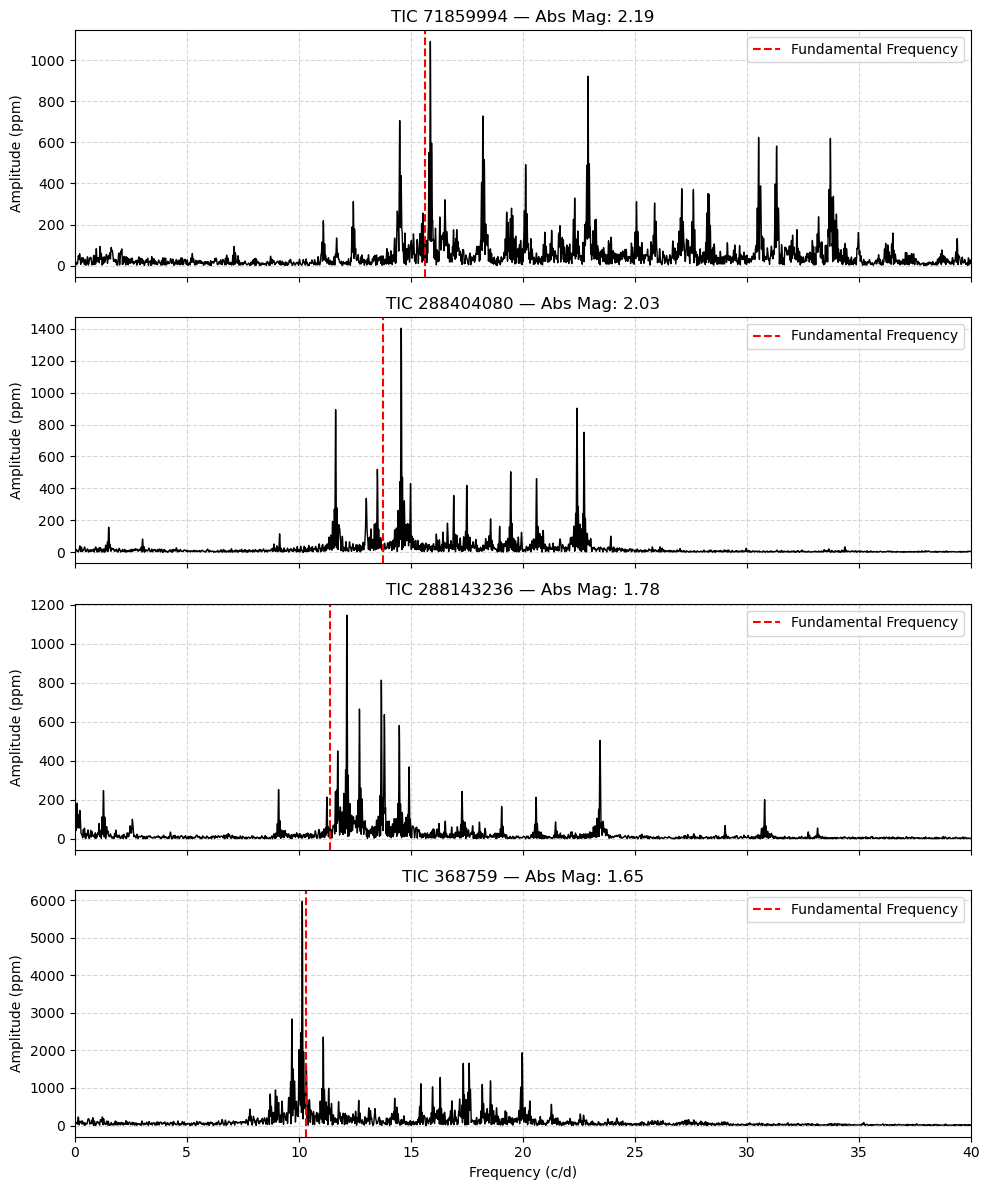

In [16]:
#Rough gallery

abs_mags_dict = {}
for tic in ids:
    result = graph_info(tic)
    if result is not None:
        _, _, _, abs_mag = result
        abs_mags_dict[tic] = abs_mag

# Sort TIC IDs by decreasing absolute magnitude (brightest at top)
sorted_tics = sorted(abs_mags_dict.keys(), key=lambda x: abs_mags_dict[x], reverse=True)
sorted_abs_mags = [abs_mags_dict[tic] for tic in sorted_tics]

# Create vertical stack of subplots
fig, axes = plt.subplots(len(sorted_tics), 1, figsize=(10, 3*len(sorted_tics)), sharex=True)

if len(sorted_tics) == 1:
    axes = [axes]  # make it iterable if only one plot

for ax, tic in zip(axes, sorted_tics):
    result = graph_info(tic)
    if result is None:
        continue
    freq, amp, fund_frequency, abs_mag = result
    
    ax.plot(freq, amp, color='black', lw=1)
    ax.axvline(fund_frequency, color='red', ls='--', label='Fundamental Frequency')
    ax.set_ylabel('Amplitude (ppm)')
    plt.xlim(0,40)
    ax.set_title(f"TIC {tic} — Abs Mag: {abs_mag:.2f}")
    ax.grid(True, ls='--', alpha=0.5)
    ax.legend()

axes[-1].set_xlabel('Frequency (c/d)')
plt.tight_layout()
plt.savefig("amplitude_gallery.png", dpi=300)
plt.show()

/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_5697/3701438308.py:78: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_5697/3701438308.py:78: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6


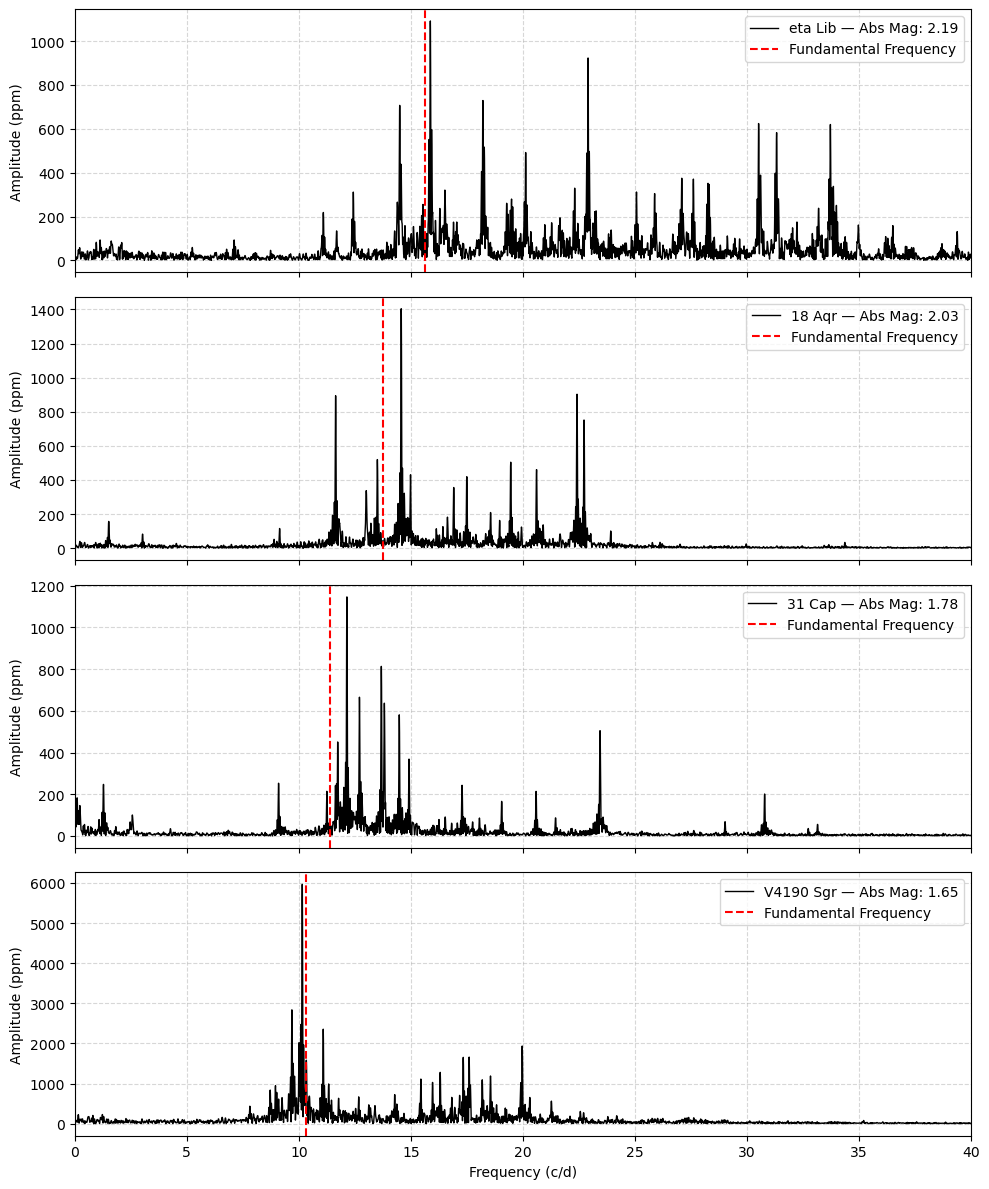

In [15]:
#Improved Gallery

# Map each TIC ID to its star name
name_dict = dict(zip(ids, names))

abs_mags_dict = {}
for tic in ids:
    result = graph_info(tic)
    if result is not None:
        _, _, _, abs_mag = result
        abs_mags_dict[tic] = abs_mag

# Sort TICs by decreasing absolute magnitude (brightest at top)
sorted_tics = sorted(abs_mags_dict.keys(), key=lambda x: abs_mags_dict[x], reverse=True)
sorted_abs_mags = [abs_mags_dict[tic] for tic in sorted_tics]

# Create vertical stack of subplots
fig, axes = plt.subplots(len(sorted_tics), 1, figsize=(10, 3 * len(sorted_tics)), sharex=True)

if len(sorted_tics) == 1:
    axes = [axes]  # make iterable if only one plot

for ax, tic in zip(axes, sorted_tics):
    result = graph_info(tic)
    if result is None:
        continue
    freq, amp, fund_frequency, abs_mag = result

    star_name = name_dict.get(tic, f"TIC {tic}")
    
    ax.plot(freq, amp, color='black', lw=1, label = f"{star_name} — Abs Mag: {abs_mag:.2f}")
    ax.axvline(fund_frequency, color='red', ls='--', label='Fundamental Frequency')
    ax.set_ylabel('Amplitude (ppm)')
    ax.set_xlim(0, 40)
    
    # Use the star's name instead of the TIC number
    ax.grid(True, ls='--', alpha=0.5)
    ax.legend()

axes[-1].set_xlabel('Frequency (c/d)')
plt.tight_layout()
plt.savefig("amplitude_gallery_improved.png", dpi=300)
plt.show()
